<a href="https://colab.research.google.com/github/neuralresearch/CS39-6/blob/boyan/TaGSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import os
import random
import networkx as nx
from matplotlib import pyplot as plt
import torch
import numpy as np

In [2]:
# download file into Colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# get the data from the drive
id = '1E07PMf68jMo-rULzHfE_q7chqgaYGsXp'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AIDS700.zip')
!ls

AIDS700.zip  sample_data


In [3]:
!unzip AIDS700.zip

Archive:  AIDS700.zip
   creating: AIDS700nef/
  inflating: __MACOSX/._AIDS700nef   
  inflating: AIDS700nef/.DS_Store    
  inflating: __MACOSX/AIDS700nef/._.DS_Store  
   creating: AIDS700nef/test/
  inflating: __MACOSX/AIDS700nef/._test  
   creating: AIDS700nef/train/
  inflating: __MACOSX/AIDS700nef/._train  
  inflating: AIDS700nef/test/6484.gexf  
  inflating: __MACOSX/AIDS700nef/test/._6484.gexf  
  inflating: AIDS700nef/test/5640.gexf  
  inflating: __MACOSX/AIDS700nef/test/._5640.gexf  
  inflating: AIDS700nef/test/6216.gexf  
  inflating: __MACOSX/AIDS700nef/test/._6216.gexf  
  inflating: AIDS700nef/test/1029.gexf  
  inflating: __MACOSX/AIDS700nef/test/._1029.gexf  
  inflating: AIDS700nef/test/2486.gexf  
  inflating: __MACOSX/AIDS700nef/test/._2486.gexf  
  inflating: AIDS700nef/test/5343.gexf  
  inflating: __MACOSX/AIDS700nef/test/._5343.gexf  
  inflating: AIDS700nef/test/34208.gexf  
  inflating: __MACOSX/AIDS700nef/test/._34208.gexf  
  inflating: AIDS700nef/test/11

# Graph Pair Generator

In [4]:
# try to visualize 101.gexf file in the train folder
g = nx.read_gexf('AIDS700nef/train/101.gexf')
print(g.nodes(data=True)) # type is the label of node, label is the unique id of node
print(g.edges(data=True)) # valence is the label of edge, id is the unique id of edge

[('7', {'type': 'C', 'label': '7'}), ('3', {'type': 'O', 'label': '3'}), ('5', {'type': 'O', 'label': '5'}), ('6', {'type': 'C', 'label': '6'}), ('1', {'type': 'S', 'label': '1'}), ('0', {'type': 'C', 'label': '0'}), ('4', {'type': 'O', 'label': '4'}), ('2', {'type': 'C', 'label': '2'})]
[('7', '2', {'valence': 2, 'id': '6'}), ('3', '1', {'valence': 2, 'id': '2'}), ('5', '1', {'valence': 1, 'id': '4'}), ('6', '2', {'valence': 1, 'id': '5'}), ('1', '0', {'valence': 1, 'id': '0'}), ('1', '4', {'valence': 2, 'id': '3'}), ('0', '2', {'valence': 1, 'id': '1'})]


In [5]:
# get all the labels of nodes and edges
dirName = 'AIDS700nef/train/'
filenames = os.listdir(dirName)
Node_Types = []
Edge_Types = []
for filename in filenames:
    if filename.endswith(".gexf"):
        temp =  nx.read_gexf(path=dirName+"/"+filename)
        for node in temp.nodes:
            temp_type = temp.nodes[node]['type']
            if temp_type not in Node_Types:
                Node_Types.append(temp_type)
        for edge in temp.edges:
            temp_type = temp.edges[edge]['valence']
            if temp_type not in Edge_Types:
                Edge_Types.append(temp_type)

print(Node_Types)
print(Edge_Types)

['C', 'S', 'O', 'N', 'Sb', 'Br', 'Cl', 'Pd', 'Co', 'Pt', 'P', 'Si', 'Bi', 'F', 'B', 'I', 'Cu', 'Pb', 'Ho', 'Tb', 'Ru', 'Hg', 'Sn', 'As', 'Li', 'Ga']
[1, 2, 3]


In [6]:
# get all the labels of nodes and edges 101.gexf
Node_Types = []
Edge_Types = []

for node in g.nodes:
    g_type = g.nodes[node]['type']
    if g_type not in Node_Types:
        Node_Types.append(g_type)
for edge in g.edges:
    g_type = g.edges[edge]['valence']
    if g_type not in Edge_Types:
        Edge_Types.append(g_type)

print(Node_Types)
print(Edge_Types)

['C', 'O', 'S']
[2, 1]


In [7]:
# graph display
def graphDisplay(g):
    node_info = nx.get_node_attributes(g, 'type')
    edge_info = dict([((n1, n2), d['valence']) for n1, n2, d in g.edges(data=True)])
    pos = nx.spring_layout(g, scale = 1)
    nx.draw(g, pos, labels=node_info)
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_info)
    plt.show()

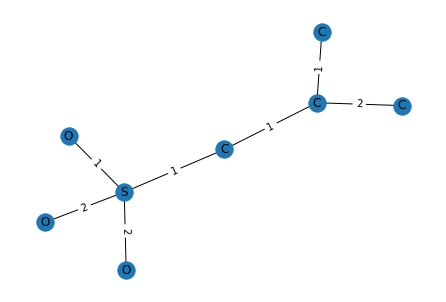

In [8]:
graphDisplay(g)

In [9]:
# graph pair generator
# target_gev is a 4-dimensional vector [NR, NID, ER, EID]
def construct_graph_pairs(graph, target_gev):
    NR = target_gev['NR']
    NID = target_gev['NID']
    ER = target_gev['ER']
    EID = target_gev['EID']

    nodeList= list(g.nodes) # ['7', '3', '5', '6', '1', '0', '4', '2']
    edgeList= list(g.edges) # [('7', '2'), ('3', '1'), ('5', '1'), ('6', '2'), ('1', '0'), ('1', '4'), ('0', '2')]

    NodeDataView = g.nodes.data()
    newGraph = g.copy()
    nodeLabels=set(nx.get_node_attributes(newGraph, "type").values())       # {'C', 'O', 'S'}
    edgeLabels=set(nx.get_edge_attributes(newGraph, "valence").values())    # {1, 2}

    def NodeRelabel(newGraph, NR):
        relabedNode=[]
        relabelDict={}
        for i in range(NR):
            nodeToBeRebel=random.choice(list(newGraph.nodes))
            while(nodeToBeRebel in relabedNode):
                nodeToBeRebel=random.choice(list(newGraph.nodes))
            relabedNode.append(nodeToBeRebel)

            relabelDict[nodeToBeRebel] = {}
            newLabel = random.choice(list(nodeLabels))
            while(newLabel == NodeDataView[nodeToBeRebel]["type"] ):
                newLabel=random.choice(list(nodeLabels))
            relabelDict[nodeToBeRebel]['type'] = newLabel
        nx.set_node_attributes(newGraph, relabelDict)
        if NR != 0:
            print('Relabel node list:', relabelDict)
            print("The new graph after node relabeling shows below: ")
            graphDisplay(newGraph)
            print("\n")
        else:
            print("NO NRs.\n")
        return newGraph

    def NodeInserted(newGraph,NID):
        newNode=[]
        for i in range(NID):
            label=random.choice(list(nodeLabels))
            newGraph.add_node(i+len(nodeList),type=label)
            newNode.append(i+len(nodeList))
        print(newNode)
        if NID != 0:
            print("The new graph after node insertion shows below: ")
            graphDisplay(newGraph)
            print("\n")
        else:
            print("NO NIDs.\n")
        return newGraph

    def EdgeDelete(newGraph,EID):
        toDel=0
        if EID>0:
            toDel=random.choice(list(range(EID)))
        deletedEdge=[]
        for i in range(toDel):
            e=random.choice(list(newGraph.edges))
            newGraph.remove_edge(*e)
            deletedEdge.append(e)
        print('Delete edge:',deletedEdge)
        return newGraph,deletedEdge,toDel

    def EdgeRelabel(newGraph,ER):
        relabedEdge=[]
        relabelDict={}
        for i in range(ER):
            edgeToBeRebel=random.choice(list(newGraph.edges))
            while(edgeToBeRebel in relabedEdge ):
                edgeToBeRebel=random.choice(list(newGraph.edges))
            relabedEdge.append(edgeToBeRebel)

            relabelDict[edgeToBeRebel]={}
            newLabel=random.choice(list(edgeLabels))
            while(newLabel ==nx.get_edge_attributes(g,'valence')[edgeToBeRebel] ):
                newLabel=random.choice(list(edgeLabels))
            relabelDict[edgeToBeRebel]['valence']=newLabel
        nx.set_edge_attributes(newGraph, relabelDict)
        print('Relable edge:',relabelDict)
        return newGraph

    def EdgeInsert(newGraph,toInsert,deletedEdge): 
        newEdges=[]
        for i in range(toInsert):
            e=random.choice(list(newGraph.edges))

            n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))
            #random select 2 node agian if edge has already existed/the edge is deleted in delete rpocess
            while(n1==n2 or (n1,n2) in list(g.edges) or (n2,n1) in list(g.edges)or (n1,n2) in deletedEdge or (n2,n1) in deletedEdge):
                n1,n2=random.choice(list(newGraph.nodes)),random.choice(list(newGraph.nodes))
            newGraph.add_edge(n1,n2,valence=random.choice(list(edgeLabels)))
            newEdges.append((n1,n2))
        print('Add edge:',newEdges)
        return newGraph 

    newGraph = NodeRelabel(newGraph,NR)
    newGraph = NodeInserted(newGraph,NID)
    newGraph,deletedEdge,toDel = EdgeDelete(newGraph,EID) 
    newGraph = EdgeRelabel(newGraph,ER) 
    newGraph = EdgeInsert(newGraph,EID-toDel,deletedEdge) 
        
    finalGEV={'NR':NR,'NID':NID,'ER':ER,'EID':EID}
    return g,newGraph,finalGEV

NO NRs.

[8]
The new graph after node insertion shows below: 


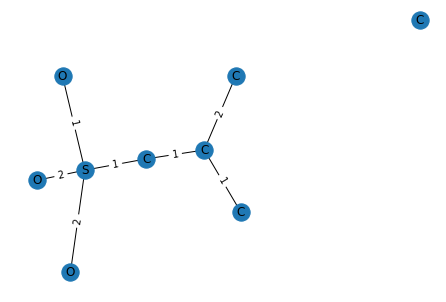



Delete edge: []
Relable edge: {}
Add edge: []


In [10]:
targetGEV={'NR':0,'NID':1,'ER':0,'EID':0}
(Graph,newGraph,GEV)=construct_graph_pairs(g, targetGEV)

# Embedding

In [15]:
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
# pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+${CUDA}.html

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self, nlm_features, nem_features, nlm_out_features, nem_out_features):
        super().__init__()
        self.conv1 = GCNConv(nlm_features, nlm_out_features)
        self.conv2 = GCNConv(nlm_out_features, nlm_out_features)
        self.conv3 = GCNConv(nem_features, nem_out_features)

    def forward(self, nlm, nem):
        # nlm.x green
        # nem.x light grey
        nlm_x = self.conv1(nlm.x, nlm.edge_index)    # orenge
        nlm_2x = self.conv2(nlm_x, nlm.edge_index)   # blue

        nem_x = self.conv3(nem.x, nem.edge_index)    # dark grey

        output1 = torch.hstack([nlm.x, nlm_x])
        output2 = torch.hstack([nlm_x, nlm_2x])

        output3 = torch.hstack([nem.x, nem_x])

        return output1, output2, output3

In [16]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 0, 2, 1, 2, 2, 3, 2, 4],
                           [1, 0, 2, 0, 2, 1, 3, 2, 4, 2]], dtype=torch.long)

x = torch.tensor([[0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0]], dtype=torch.float)

x2 = torch.tensor([[2], [2], [2], [2], [2]], dtype=torch.float)

nlm = Data(x=x, edge_index=edge_index)

nem = Data(x=x2, edge_index=edge_index)

In [17]:
net = Net(nlm.num_node_features, nem.num_node_features, nlm.num_node_features, 1)

In [18]:
o1, o2, o3 = net(nlm, nem)
o1

tensor([[ 0.0000,  0.0000,  1.0000, -0.2358,  0.3331,  0.7467],
        [ 0.0000,  1.0000,  0.0000, -0.2358,  0.3331,  0.7467],
        [ 0.0000,  1.0000,  0.0000, -0.3142,  0.0421,  1.0838],
        [ 0.0000,  1.0000,  0.0000, -0.4273,  0.1085,  0.6024],
        [ 1.0000,  0.0000,  0.0000, -0.1117, -0.3658,  0.6635]],
       grad_fn=<CatBackward0>)

In [19]:
import torch.nn.functional as F

torch.sum(o1, dim=0)

tensor([ 1.0000,  3.0000,  1.0000, -1.3249,  0.4510,  3.8430],
       grad_fn=<SumBackward1>)